In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.io
from VAE import myVAE
from classifier_cnn import Classifier, Classifier2D, addNoise2Batch
from GAN_PA import Discriminator

from scipy.interpolate import interp1d
import csv
from classifier_cnn_getAccForRFF import getCfgs, newAccDict

In [32]:
def corelation(x, y): #x,y are both n-d vector
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    cov_xy=0
    var_x=0
    var_y=0
    for i in range(x.shape[0]):
        cov_xy+=(x[i]-x_mean)*(y[i]-y_mean)
        var_x+=(x[i]-x_mean)*(x[i]-x_mean)
        var_y+=(y[i]-y_mean)*(y[i]-y_mean)
    corr = cov_xy/(np.sqrt(var_x*var_y))
    return corr

def classify_by_correlation(signals, datasets_220, targets_220):
    batch_size=signals.shape[0]
    targets=np.zeros((batch_size, 12))
    targets_int=np.zeros((batch_size,))
    for bc in range(batch_size):
        r=np.zeros((220,))
        for i in range(datasets_220.shape[0]):
            r_real = corelation(signals[bc][0], datasets_220[i][0])
            r_imag = corelation(signals[bc][1], datasets_220[i][1])
            r[i] = (r_real+r_imag)/2
        rff_idx = np.argmax(r)
        targets[bc]=targets_220[rff_idx]
        targets_int[bc]=rff_idx
    return targets, targets_int

In [50]:
def classify_by_error(signals, datasets_220, targets_220):
    batch_size=signals.shape[0]
    targets=np.zeros((batch_size, 12))
    targets_int=np.zeros((batch_size,))
    for bc in range(batch_size):
        r=np.zeros((220,))
        for i in range(datasets_220.shape[0]):
            error = np.sum(signals[bc] - datasets_220[i])
            r[i] = error
        rff_idx = np.argmin(r)
        targets[bc]=targets_220[rff_idx]
        targets_int[bc]=rff_idx
    return targets, targets_int

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)

device:  cuda


In [7]:
import os
path = "../../../RFF-RL/MCsim_for_generative_crosstest/"
all_mcsignals=[]

files = os.listdir(path)
for file in files:
    print("\nfile:", file)
    if file.split('.')[-1]!='csv':
        continue
    with open(path+file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        print(spamreader)
        i=0
        title = next(spamreader)
        total_col = len(title)
        total_points = total_col//3
        print("total column in csv.file: ", total_col)
        print("total points in MC sim: ", total_points)
        # read_all_signs = [[[], [], []] for _ in range(total_points)]
        read_all_signs = np.zeros((total_points, 3, 801))
        row_idx=0
        for row in spamreader:
            for i in range(len(row)):
                point_idx = i//3
                read_all_signs[point_idx, i%3, row_idx]=row[i]
            row_idx+=1     
    # read_all_signs = np.array(read_all_signs)
    if all_mcsignals==[]:
        all_mcsignals=read_all_signs
    else:
        all_mcsignals = np.concatenate((all_mcsignals, read_all_signs), axis=0)

    print("read_all_signals shape: ", read_all_signs.shape)
# all_mcsignals = np.asarray(all_mcsignals)
print("all mc signals: ", all_mcsignals.shape)


file: c7.csv
total column in csv.file:  105
total points in MC sim:  35
read_all_signals shape:  (35, 3, 801)

file: c6.csv
total column in csv.file:  171
total points in MC sim:  57


C:\Users\juntingd\AppData\Local\Temp\ipykernel_51096\1755545528.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if all_mcsignals==[]:


read_all_signals shape:  (57, 3, 801)

file: c5.csv
total column in csv.file:  171
total points in MC sim:  57
read_all_signals shape:  (57, 3, 801)

file: c4.csv
total column in csv.file:  174
total points in MC sim:  58
read_all_signals shape:  (58, 3, 801)

file: c3.csv
total column in csv.file:  309
total points in MC sim:  103
read_all_signals shape:  (103, 3, 801)

file: c1.csv
total column in csv.file:  291
total points in MC sim:  97
read_all_signals shape:  (97, 3, 801)

file: c0.csv
total column in csv.file:  588
total points in MC sim:  196
read_all_signals shape:  (196, 3, 801)

file: MCSim_603_2_800.npy

file: MCSim_norm_603_2_800.npy

file: MCSim_cubic_603_2_800.npy
all mc signals:  (603, 3, 801)


In [23]:
datasets = np.zeros((all_mcsignals.shape[0], 2, 321))
datasets[:,0,:] = all_mcsignals[:,1,:321]
datasets[:,1,:] = all_mcsignals[:,2,:321]
# datasets = 2*((datasets - datasets.min())/(datasets.max() - datasets.min()))-1
datasets = datasets/np.max((np.abs(datasets.max()), np.abs(datasets.min())))
datasets_cubic=np.zeros((all_mcsignals.shape[0],2,800))

x = np.linspace(0, 800, num=321, endpoint=True)
xnew = np.linspace(0, 800, num=800, endpoint=True)

for i in range(all_mcsignals.shape[0]):
    for ch in range(datasets.shape[1]):
        y = datasets[i,ch,:]
        f_cubic = interp1d(x, y, kind='cubic', fill_value="extrapolate")
        datasets_cubic[i,ch,:]=f_cubic(xnew)
datasets_cubic = datasets_cubic/np.max((np.abs(datasets_cubic.max()), np.abs(datasets_cubic.min())))
datasets_cubic[0, 1, :] = -datasets_cubic[0, 1, :] # datasets_cubic[0, 1, :] has the same sign as the preamble, need to add "-" when dealing with measurement results

# plt.plot(datasets_cubic[0, 0, :])
# plt.plot(datasets_cubic[0, 1, :])                                
print("datasets_cubic: ", datasets_cubic.shape)
print("datasets_cubic range: ", datasets_cubic.max(), datasets.min())
# print("targets: ", targets.shape)
print("datasets range: ", datasets.max(), datasets.min())

datasets_cubic:  (603, 2, 800)
datasets_cubic range:  1.0 -0.9999465427817911
datasets range:  1.0 -0.9999465427817911


In [24]:
# np.save(path+"MCSim_cubic_603_2_800_new.npy", datasets_cubic)
# np.save(path+"MCSim_norm_603_2_800_new.npy", datasets)

In [51]:
PATH="../../../RFF-RL/TcasRFFData/"
dataFile="ChipCAIRprocessedType3BlockOS20len800comb220V1p2Quant16.npz"
file = np.load(PATH+dataFile)
items = file.files
items = file.files
datasets_all, targets_all = file[items[0]], file[items[1]]
datasets_220=np.zeros((220, 2, 800))
targets_220=np.zeros((220, 12))
for i in range(220):
    datasets_220[i]= datasets_all[i*730]
    targets_220[i]=targets_all[i*730]
datasets_cubic_noised = addNoise2Batch(datasets_cubic, snr=5)
targets, targets_int = classify_by_error(datasets_cubic, datasets_220=datasets_220, targets_220=targets_220)
print("targets shape:{}".format(targets_int.shape))
print(targets_int[:20])

targets shape:(603,)
[35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35. 35.
 35. 35.]


targets shape:(603,)


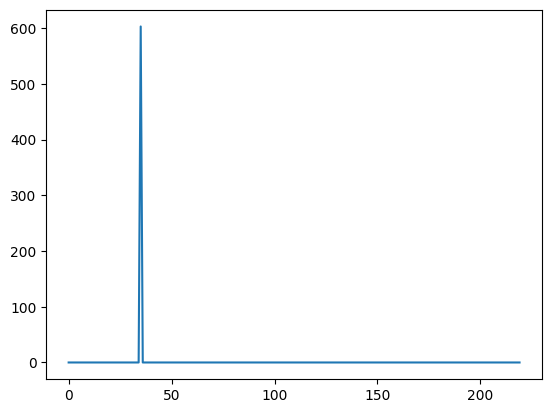

In [52]:
cnt=np.zeros(220)
print("targets shape:{}".format(targets_int.shape))
for i in range(targets_int.shape[0]):
    cnt[int(targets_int[i])]+=1
plt.plot(cnt)

In [32]:
batch_size=128
datasets = torch.tensor(datasets_cubic).to(device)
rffDataset=Data.TensorDataset(datasets)
testLoader = Data.DataLoader(rffDataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_acc=[]
testAccDict_curve=[]
configs = getCfgs()
test_acc_dict = newAccDict(configs)

batch_size = 128
snrsdB = [35, 30, 25, 20, 15, 10, 5]

gan_load = torch.load("./checkpoint/gan/gan_1class_epoch1000.gan")
generator=gan_load['generator']
discriminator=gan_load['discriminator']
classifier=gan_load['classifier']
real_label = Variable(torch.ones(batch_size, 1), requires_grad=False).to(device)
fake_label = Variable(torch.zeros(batch_size, 1), requires_grad=False).to(device)
real_label_bool = Variable(torch.ones(batch_size, 1)>0, requires_grad=False).to(device)
fake_label_bool = Variable(torch.zeros(batch_size, 1)>0, requires_grad=False).to(device)

MCsim_result_acc=torch.zeros((len(snrsdB)))
MCsim_result_biacc=torch.zeros((len(snrsdB)))
for snr_idx in range(len(snrsdB)):
    snrdB=snrsdB[snr_idx]
    snr=10**(snrdB/10)
    test_acc=[]
    test_acc_fake=[]
    test_biacc = []
    test_biacc_fake = []
    for batch_idx, [data] in enumerate(testLoader):
        data=torch.tensor(data, dtype=torch.float).to(device)
        # labels = classifier.forward(data)
        # _, cfg_idx = torch.topk(labels, 9, axis=1)
        labels = classify_by_correlation(data.detach().cpu().numpy(), datasets_220, targets_220)
        labels = torch.tensor(labels, dtype=torch.float32).to(device)
        _, cfg_idx = torch.topk(labels, 9, axis=1)
        cfg_idx = cfg_idx.cpu().detach().numpy()
        for i in range(batch_size):
            cfg = np.zeros(12)
            cfg[cfg_idx[i]] = 1

        for bc in range(batch_size):
            signal_power = torch.mean(data[bc][0]**2+data[bc][1]**2)
            noise_power=signal_power/snr
            noise=torch.zeros((2,800))
            noise[0] = torch.sqrt(noise_power/2)*torch.randn(800,).to(device)
            noise[1] = torch.sqrt(noise_power/2)*torch.randn(800,).to(device)
            data[bc] +=noise.to(device)
        
        fake_out_d = discriminator.forward(data)
        fake_out_d_bool = (fake_out_d-0.5)>0
        test_biacc_fake.append((fake_out_d_bool==fake_label_bool).sum()/fake_out_d.shape[0])

        # labels_ = classifier.forward(data)
        # _, cfg_ = torch.topk(labels_, 9, axis=1)
        # cfg_ = cfg_.cpu().detach().numpy()
        _, cfg = torch.topk(labels, 9, axis=1)
        
        labels_ = classify_by_correlation(data.detach().cpu().numpy(), datasets_220, targets_220)
        _, cfg_ = torch.topk(torch.tensor(labels_).to(device), 9, axis=1)
        cfg_ = cfg_.cpu().detach().numpy()
        for i in range(batch_size):
            y_ = list(cfg_[i])
            y = list(cfg[i])
            y_.sort()
            y.sort()
            test_acc_fake.append(y_==y)

        test_acc_fake = sum(test_acc_fake)/(len(test_acc_fake))
        test_biacc_fake = sum(test_biacc_fake)/(len(test_biacc_fake))
        MCsim_result_acc[snr_idx]=test_acc_fake
        MCsim_result_biacc[snr_idx]=test_biacc_fake
        print("snr {}dB, acc_fake:{:.3f},biacc_fake:{:3f}".format(snrdB, test_acc_fake, test_biacc_fake))

DeferredCudaCallError: CUDA call failed lazily at initialization with error: module 'torch' has no attribute 'version'

CUDA call was originally invoked at:

['  File "d:\\Installation\\Anaconda3\\lib\\runpy.py", line 197, in _run_module_as_main\n    return _run_code(code, main_globals, None,\n', '  File "d:\\Installation\\Anaconda3\\lib\\runpy.py", line 87, in _run_code\n    exec(code, run_globals)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel_launcher.py", line 17, in <module>\n    app.launch_new_instance()\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 992, in launch_instance\n    app.start()\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 711, in start\n    self.io_loop.start()\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\tornado\\platform\\asyncio.py", line 215, in start\n    self.asyncio_loop.run_forever()\n', '  File "d:\\Installation\\Anaconda3\\lib\\asyncio\\base_events.py", line 601, in run_forever\n    self._run_once()\n', '  File "d:\\Installation\\Anaconda3\\lib\\asyncio\\base_events.py", line 1905, in _run_once\n    handle._run()\n', '  File "d:\\Installation\\Anaconda3\\lib\\asyncio\\events.py", line 80, in _run\n    self._context.run(self._callback, *self._args)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelbase.py", line 510, in dispatch_queue\n    await self.process_one()\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelbase.py", line 499, in process_one\n    await dispatch(*args)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelbase.py", line 406, in dispatch_shell\n    await result\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\kernelbase.py", line 729, in execute_request\n    reply_content = await reply_content\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\ipkernel.py", line 411, in do_execute\n    res = shell.run_cell(\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\ipykernel\\zmqshell.py", line 531, in run_cell\n    return super().run_cell(*args, **kwargs)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py", line 3006, in run_cell\n    result = self._run_cell(\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py", line 3061, in _run_cell\n    result = runner(coro)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\IPython\\core\\async_helpers.py", line 129, in _pseudo_sync_runner\n    coro.send(None)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py", line 3266, in run_cell_async\n    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py", line 3445, in run_ast_nodes\n    if await self.run_code(code, result, async_=asy):\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\IPython\\core\\interactiveshell.py", line 3505, in run_code\n    exec(code_obj, self.user_global_ns, self.user_ns)\n', '  File "C:\\Users\\juntingd\\AppData\\Local\\Temp\\ipykernel_21552\\3215983159.py", line 2, in <module>\n    import torch\n', '  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked\n', '  File "<frozen importlib._bootstrap_external>", line 850, in exec_module\n', '  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\torch\\__init__.py", line 1146, in <module>\n    _C._initExtension(manager_path())\n', '  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load\n', '  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked\n', '  File "<frozen importlib._bootstrap>", line 680, in _load_unlocked\n', '  File "<frozen importlib._bootstrap_external>", line 850, in exec_module\n', '  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\torch\\cuda\\__init__.py", line 197, in <module>\n    _lazy_call(_check_capability)\n', '  File "d:\\Installation\\Anaconda3\\lib\\site-packages\\torch\\cuda\\__init__.py", line 195, in _lazy_call\n    _queued_calls.append((callable, traceback.format_stack()))\n']

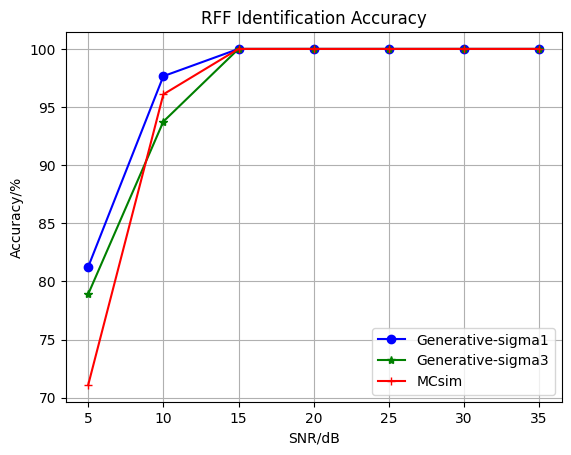

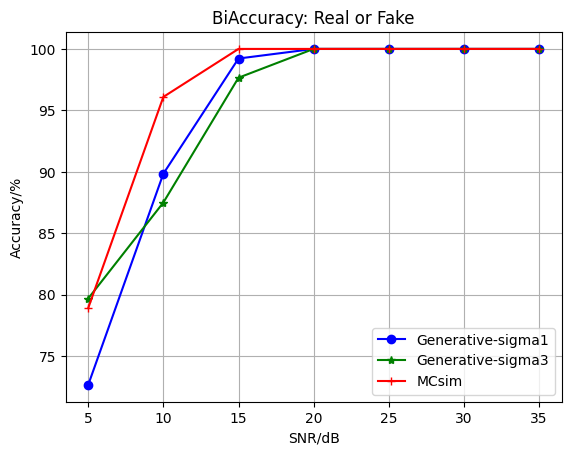

In [23]:
# gan_acc=gan_acc.detach().cpu().numpy()
# gan_biacc=gan_biacc.detach().cpu().numpy()
# MCsim_result_acc=MCsim_result_acc.detach().cpu().numpy()
# MCsim_result_biacc=MCsim_result_biacc.detach().cpu().numpy()

plt.plot(snrsdB, gan_acc[:,0]*100, 'bo-', label='Generative-sigma1')
# plt.plot(snrsdB, gan_acc[:,1]*100, '^-', label='Generative-sigma2')
plt.plot(snrsdB, gan_acc[:,2]*100, 'g*-', label='Generative-sigma3')
plt.plot(snrsdB, MCsim_result_acc*100, 'r+-', label='MCsim')
plt.xlabel("SNR/dB")
plt.ylabel("Accuracy/%")
plt.xticks(snrsdB)
plt.title("RFF Identification Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.plot(snrsdB, gan_biacc[:,0]*100, 'bo-', label='Generative-sigma1')
# plt.plot(snrsdB, gan_biacc[:,1]*100, '^-', label='Generative-sigma2')
plt.plot(snrsdB, gan_biacc[:,2]*100, 'g*-', label='Generative-sigma3')
plt.plot(snrsdB, MCsim_result_biacc*100, 'r+-', label='MCsim')
plt.xlabel("SNR/dB")
plt.ylabel("Accuracy/%")
plt.xticks(snrsdB)
plt.title("BiAccuracy: Real or Fake")
plt.legend()
plt.grid()
plt.show()
